Run these before you start (recommended inside a virtualenv / conda env):

In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit-aer qiskit-ibm-runtime

1. Imports and Setup
We first import Python’s numerical libraries and Qiskit for quantum simulation.

In [5]:
import numpy as np
from numpy import pi, sqrt, exp
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

import warnings
warnings.filterwarnings("ignore")


2.1. Initialization
We set up:

Number of qubits → determines spatial resolution (nx = 2^n_qubits points)

Viscosity, time step, total time

Boundary conditions (u_left, u_right)

Quantum backend (Aer simulator)

In [6]:
class TrueQuantumBurgersSolver:
    def __init__(self, n_qubits=4, viscosity=0.01, T=0.05, dt=0.01,
                 u_left=1.0, u_right=0.0, shots=4096):

        self.n_qubits = int(n_qubits)
        self.nx = 2 ** self.n_qubits
        self.viscosity = float(viscosity)
        self.T = float(T)
        self.dt = float(dt)
        self.u_left = float(u_left)
        self.u_right = float(u_right)
        self.shots = int(shots)

        # Spatial grid
        self.L = 1.0
        self.x = np.linspace(0.0, self.L, self.nx)
        self.dx = self.x[1] - self.x[0]

        # Quantum backend
        self.backend = AerSimulator()

        print("Initialized TrueQuantumBurgersSolver")
        print(f"  Qubits: {self.n_qubits}, grid points: {self.nx}")
        print(f"  viscosity={self.viscosity}, dt={self.dt}, T={self.T}")
        print(f"  BCs: u(0)={self.u_left}, u(1)={self.u_right}")
        print(f"  Shots: {self.shots}\n")


2.2. Initial Condition — Riemann Step
We’ll start with a step function (shock-like) profile.

In [7]:
def initial_condition_riemann(self):
    """Riemann step initial condition."""
    u0 = np.where(self.x <= 0.5, 1.0, 0.0)
    u0[0] = self.u_left
    u0[-1] = self.u_right
    return u0


2.3. Amplitude Encoding
We need to encode the field u(x) into a quantum statevector.

Magnitude: proportional to u(x) values (normalized)

Phase: proportional to cumulative sum (inspired by Madelung transform)

In [8]:
def amplitude_encode(self, u_field):
    # Shift so values are non-negative
    nonneg = u_field - np.min(u_field)
    if np.allclose(nonneg, 0):
        mags = np.ones_like(nonneg) / len(nonneg)
    else:
        mags = nonneg / np.sum(nonneg)

    # Phase: cumulative sum scaled to [-pi, pi]
    cumsum = np.cumsum(u_field) * self.dx
    if np.max(np.abs(cumsum)) < 1e-12:
        phases = np.zeros_like(cumsum)
    else:
        phases = (cumsum / np.max(np.abs(cumsum))) * pi

    amps = np.sqrt(mags) * np.exp(1j * phases)

    # Pad/trim to match 2^n_qubits
    if len(amps) < self.nx:
        padded = np.zeros(self.nx, dtype=complex)
        padded[: len(amps)] = amps
        amps = padded
    elif len(amps) > self.nx:
        amps = amps[: self.nx]

    # Normalize
    norm = np.linalg.norm(amps)
    if norm < 1e-12:
        amps = np.zeros(self.nx, dtype=complex)
        amps[0] = 1.0
    else:
        amps /= norm

    return Statevector(amps)


2.4. Building the Evolution Circuit
For one time step:

Apply QFT → go to momentum space

Apply k-dependent Rz (diffusion/kinetic term)

Apply inverse QFT → back to position space

Apply position-dependent phases (nonlinear term)




In [9]:
def build_evolution_circuit(self, u_field):
    qreg = QuantumRegister(self.n_qubits, "q")
    creg = ClassicalRegister(self.n_qubits, "c")
    qc = QuantumCircuit(qreg, creg, name="evolution_step")

    # QFT
    qc.append(QFT(self.n_qubits), qreg)
    qc.barrier()

    # k-space diffusion-like phases
    for m in range(self.nx):
        wire = m % self.n_qubits
        k = 2.0 * pi * m / self.L
        phase = -self.viscosity * (k ** 2) * self.dt
        qc.rz(phase, qreg[wire])

    qc.barrier()
    qc.append(QFT(self.n_qubits).inverse(), qreg)
    qc.barrier()

    # Position-space nonlinear term
    for idx in range(self.nx):
        wire = idx % self.n_qubits
        angle = -u_field[idx] * self.dt
        qc.rz(angle, qreg[wire])
        if wire > 0:
            qc.crz(0.1 * angle, qreg[wire - 1], qreg[wire])

    qc.barrier()
    qc.measure(qreg, creg)
    return qc


2.5. Running the Quantum Execution
Instead of actually preparing the amplitude state with gates,
we directly evolve the Statevector in memory, then sample measurements.

In [10]:
def run_quantum_execution(self, initial_statevec, circuit):
    evolved_sv = initial_statevec.evolve(circuit.remove_final_measurements(inplace=False))

    # Convert to measurement counts
    probs = np.abs(evolved_sv.data) ** 2
    probs /= np.sum(probs)
    outcomes = np.random.multinomial(self.shots, probs)

    counts = {}
    for idx, cnt in enumerate(outcomes):
        if cnt > 0:
            bitstr = format(idx, "b").zfill(self.n_qubits)
            counts[bitstr] = int(cnt)

    transpiled = transpile(circuit, self.backend)
    return counts, transpiled


2.6. Decoding Measurements to a Field
We take measurement probabilities and map them back to a velocity-like profile.

In [11]:
def measurements_to_field(self, counts, u_prev):
    probs = np.zeros(self.nx)
    total = sum(counts.values()) if counts else 1
    for bitstr, c in counts.items():
        idx = int(bitstr, 2)
        if idx < self.nx:
            probs[idx] = c / total

    probs = probs + 1e-12
    probs /= np.sum(probs)

    vel_from_probs = (probs - np.min(probs)) / (np.max(probs) - np.min(probs) + 1e-12)
    vel_from_probs = vel_from_probs * (np.max(u_prev) - np.min(u_prev) + 1e-12) + np.min(u_prev)

    blend_alpha = min(0.5, self.dt)
    u_new = (1 - blend_alpha) * u_prev + blend_alpha * vel_from_probs

    u_new[0] = self.u_left
    u_new[-1] = self.u_right
    u_new[1:-1] = 0.5 * u_new[1:-1] + 0.25 * (u_new[0:-2] + u_new[2:])
    u_new = np.clip(u_new, -5.0, 5.0)
    return u_new


In [12]:
def quantum_time_step(self, u_current):
    sv = self.amplitude_encode(u_current)
    qc = self.build_evolution_circuit(u_current)
    counts, transpiled = self.run_quantum_execution(sv, qc)
    u_next = self.measurements_to_field(counts, u_current)

    alpha = self.viscosity * self.dt / (self.dx ** 2)
    if alpha > 0.2:
        u_next[1:-1] = (u_next[1:-1] + alpha * (u_next[:-2] + u_next[2:])) / (1 + 2 * alpha)

    return u_next, transpiled, counts


In [13]:
def solve(self, max_steps=None, verbose=True):
    u = self.initial_condition_riemann()
    t_points = [0.0]
    u_hist = [u.copy()]
    circuit_list = []
    counts_list = []

    n_steps = int(np.ceil(self.T / self.dt))
    if max_steps is not None:
        n_steps = min(n_steps, max_steps)

    t = 0.0
    for step in range(n_steps):
        if verbose:
            print(f"Step {step+1}/{n_steps}  t={t:.4f}  max|u|={np.max(np.abs(u)):.6f}")
        u, transpiled, counts = self.quantum_time_step(u)
        t += self.dt
        t_points.append(t)
        u_hist.append(u.copy())
        circuit_list.append(transpiled)
        counts_list.append(counts)

        if np.isnan(np.max(u)) or np.max(np.abs(u)) > 1e3:
            print("Stability problem encountered; stopping early.")
            break

    if verbose:
        print("Quantum evolution finished.")
        print(f"Executed steps: {len(circuit_list)}")

    return np.array(t_points), np.array(u_hist), circuit_list, counts_list


2.9. Plotting the Solution
We’ll make:

Snapshots in time

Space-time contour plot

Optional entropy plot

Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.05
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096

Step 1/5  t=0.0000  max|u|=1.000000
Step 2/5  t=0.0100  max|u|=1.000000
Step 3/5  t=0.0200  max|u|=1.000000
Step 4/5  t=0.0300  max|u|=1.000000
Step 5/5  t=0.0400  max|u|=1.000000
Quantum evolution finished.
Executed steps: 5

Summary of executed quantum circuits:
 Step 1: depth=22, gates=42, distinct_outcomes=16
 Step 2: depth=22, gates=42, distinct_outcomes=16
 Step 3: depth=22, gates=43, distinct_outcomes=16
 Step 4: depth=25, gates=46, distinct_outcomes=16
 Step 5: depth=25, gates=47, distinct_outcomes=15


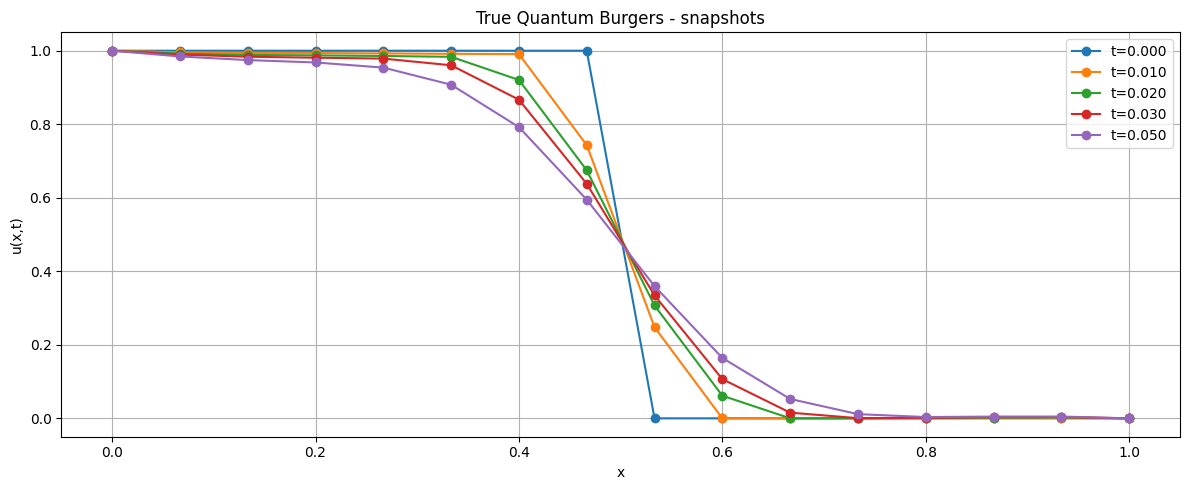

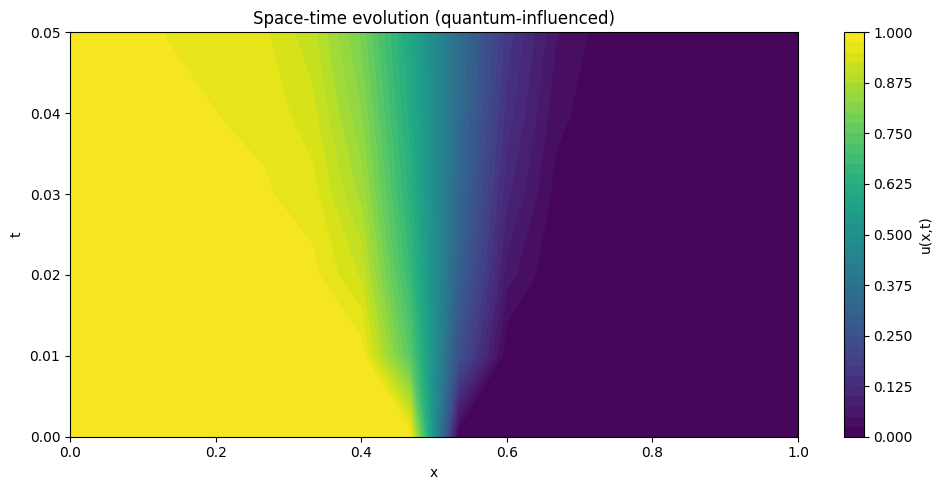

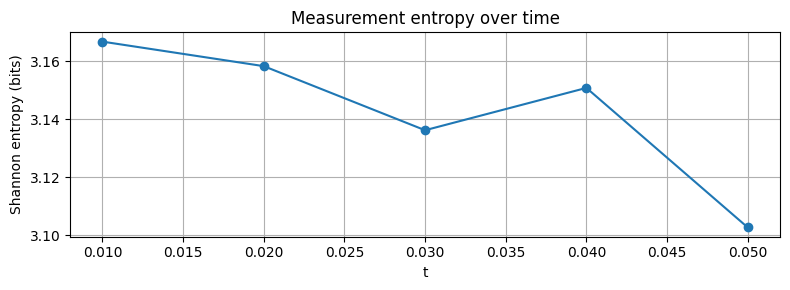

In [4]:


    def plot_solution(self, t_points, u_hist, counts_list=None):
        """Two-panel plot: snapshots and space-time contour. Optionally show entropy plot."""
        plt.figure(figsize=(12, 5))
        # snapshots
        n_snap = min(5, len(t_points))
        indices = np.linspace(0, len(t_points) - 1, n_snap, dtype=int)
        for idx in indices:
            plt.plot(self.x, u_hist[idx], label=f"t={t_points[idx]:.3f}", marker="o")
        plt.xlabel("x")
        plt.ylabel("u(x,t)")
        plt.title("True Quantum Burgers - snapshots")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # space-time contour
        plt.figure(figsize=(10, 5))
        X, T = np.meshgrid(self.x, t_points)
        plt.contourf(X, T, u_hist, levels=40, cmap="viridis")
        plt.colorbar(label="u(x,t)")
        plt.xlabel("x")
        plt.ylabel("t")
        plt.title("Space-time evolution (quantum-influenced)")
        plt.tight_layout()
        plt.show()

        # entropy from counts (if provided)
        if counts_list:
            entropies = []
            for counts in counts_list:
                total = sum(counts.values()) if counts else 1
                probs = np.array([c / total for c in counts.values()]) if counts else np.array([1.0])
                ent = -np.sum(probs * np.log2(probs + 1e-12))
                entropies.append(ent)
            plt.figure(figsize=(8, 3))
            plt.plot(t_points[1 : 1 + len(entropies)], entropies, "-o")
            plt.xlabel("t")
            plt.ylabel("Shannon entropy (bits)")
            plt.title("Measurement entropy over time")
            plt.grid(True)
            plt.tight_layout()
            plt.show()


if __name__ == "__main__":
    # Instantiate solver (example configuration)
    solver = TrueQuantumBurgersSolver(
        n_qubits=4,      # 16 grid points
        viscosity=0.01,
        T=0.05,
        dt=0.01,
        u_left=1.0,
        u_right=0.0,
        shots=4096,
    )

    # Run for a few steps (limit for demonstration)
    t_pts, u_hist, circuits, counts = solver.solve(max_steps=5, verbose=True)

    # Basic analysis prints
    print("\nSummary of executed quantum circuits:")
    for i, qc in enumerate(circuits):
        print(f" Step {i+1}: depth={qc.depth()}, gates={len(qc.data)}, distinct_outcomes={len(counts[i])}")

    # Plot results
    solver.plot_solution(t_pts, u_hist, counts)